# Understanding the Housing Market in King County, WA - Pt. 2

![Second House](images/house2.jpg)

## Author: [Patricio Contreras](https://www.linkedin.com/in/pcontreras97/)

This part of the project is concerned with fitting a model with the cleaned and transformed data from [Part 1](HousingProject.ipynb).  In order to optimise model performance, this will be an iterative process in which we fit a model, evaluate its performance, and assess how we can improve it.

In [1]:
# importing Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# reading in both data frames from Part 1!
df = pd.read_csv("data/P1_df.csv")
df_transformed = pd.read_csv("data/P1_df_transformed.csv")

# converting date column to appropriate data type
df.date = pd.to_datetime(df.date)
df_transformed.date = pd.to_datetime(df_transformed.date)

df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1,1180,5650,1,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,3,2570,7242,2,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1,770,10000,1,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3,1960,5000,1,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2,1680,8080,1,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [2]:
print("We have", df.shape[0], "rows.")

We have 20667 rows.


In [3]:
# first 5 rows of transformed data frame
df_transformed.head()

,id,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,log_sqft_above,log_sqft_living,log_sqft_lot,log_sqft_living15,log_sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1,1,0,0,3,7,...,1955,0,98178,47.5112,-122.257,7.073270,7.073270,8.639411,7.200425,8.639411
1,6414100192,2014-12-09,538000.0,3,3,2,0,0,3,7,...,1951,1991,98125,47.7210,-122.319,7.682482,7.851661,8.887653,7.432484,8.941022
2,5631500400,2015-02-25,180000.0,2,1,1,0,0,3,6,...,1933,0,98028,47.7379,-122.233,6.646391,6.646391,9.210340,7.908387,8.994917
3,2487200875,2014-12-09,604000.0,4,3,1,0,0,5,7,...,1965,0,98136,47.5208,-122.393,6.956545,7.580700,8.517193,7.215240,8.517193
4,1954400510,2015-02-18,510000.0,3,2,1,0,0,3,8,...,1987,0,98074,47.6168,-122.045,7.426549,7.426549,8.997147,7.495542,8.923058


In [4]:
print("We have", df_transformed.shape[0], "rows.")

We have 20667 rows.


As seen by the output above, we are working with the same data frames we left off Part I.  Both have the same amount of rows and columns.  `df_transformed` is the data frame with log transformations while `df` is the data frame with only clean data (no transformations).

Before moving forward, a quick refresher on what each column represents:

* **id** - unique identifier for a house
* **date** - date of the home sale
* **price** -  price of each home sold
* **bedrooms** -  number of bedrooms
* **bathrooms** -  number of bathrooms
* **sqft_living** -  square footage of the house's interior living space
* **sqft_lot** -  square footage of the land space
* **floors** -  number of floors
* **waterfront** - does the house have a view to the waterfront?
* **view** - an index from 0 to 4 of how good the view of the property was
* **condition** - an index from 1 to 5 on the condition of the house
* **grade** - an index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design
* **sqft_above** - square feet above ground
* **sqft_basement** - square feet below ground
* **yr_built** - the year the house was initially built
* **yr_renovated** - the year of the house's last renovation (0 if never renovated)
* **zipcode** - zip
* **lat** - latitude coordinate
* **long** - longitude coordinate
* **sqft_living15** - average size of interior housing living space for the closest 15 houses, in square feet
* **sqft_lot15** - average size of land lot for the closest 15 houses, in square feet

## 4. Modeling

Before we fit a regression model, it is important to consider the assumptions of regression modeling:

### Assumptions for Linear Regression

1 - there exists a **linear relationship** between the response variable (Y) and predictor (X).

2 - the **model residuals** should follow a normal distribution.

3 - the **model residuals** should have a mean of around 0 and a constant spread

4 - the **independent/predictor variables** are not highly correlated with each other

### Constructing our Baseline Model

We'll first construct a naïve, "baseline model" where we use the pre-transformed data (`df`) and neglect the assumptions of linear regression.  This way, we always have a basis of comparison and can see how tweaking it can improve (or worsen) the performance!  This baseline model will have `price` as the **target/response variable** and `bedrooms`, `bathrooms`, `sqft_living`, `sqft_above`, `yr_built`, and `zipcode` as **independent/predictor variables**:

In [5]:
# import statsmodels since it's easy to calculate summary statistics
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Y
response = "price"
# X
baseline_predictors = ["bedrooms", "bathrooms", "sqft_living", "sqft_above", 
                       "yr_built"]
# R-styled formula
f = response + " ~ " + " + ".join(baseline_predictors)
# fit the model
baseline_model = ols(formula = f, data = df).fit()

### Evaluating Baseline Model

Now that we've fit the baseline model (again, with no transformations and neglecting a couple regression assumptions), let's see how well it did.

To assess how well a model performed, we'll obtain the *Adjusted R-squared* statistic, inspect the residuals, and conduct 5-fold cross validation to see how well it performs on unseen data.  After the 5-fold cross validation, we'll record the mean squared error (MSE) to compare it to future models!

In [6]:
train_MSEs = []
test_MSEs = []

baseline_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     4114.
Date:                Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:04:30   Log-Likelihood:            -2.8362e+05
No. Observations:               20667   AIC:                         5.672e+05
Df Residuals:                   20661   BIC:                         5.673e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    5.919e+06   1.31e+05     45.339      0.000    5.66e+06    6.18e+06
bedrooms    -6.405e+04   2343.055    -27.334      0.000   -6.86e+04   -5.95e+04
bathrooms    5.837e+04   2883.207     20.245      0.000    5.27e+04     6.4e+04
sqft_living   253.9959      4.375     58.062      0.000     245.421     262.570
sqft_above     34.0271      4.219      8.065      0.000      25.758      42.296
yr_built    -2993.2235     67.577    -44.294      0.000   -3125.679   -2860.768
==============================================================================
Omnibus:                    10623.986   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           163511.256
Skew:                           2.109   Prob(JB):                         0.00
Kurtosis:                      16.119   Cond. No.                     2.92e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.92e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Ouch!  Not a great start.  Baseline model has an adjusted R-squared value of 0.499.  This means that only 49.9% of the variability in price is explained by the predictors.  It is important to note though that all the predictors are significant with a p-value < 0.05.

Now, we check if this model met the regression assumptions about the residuals!

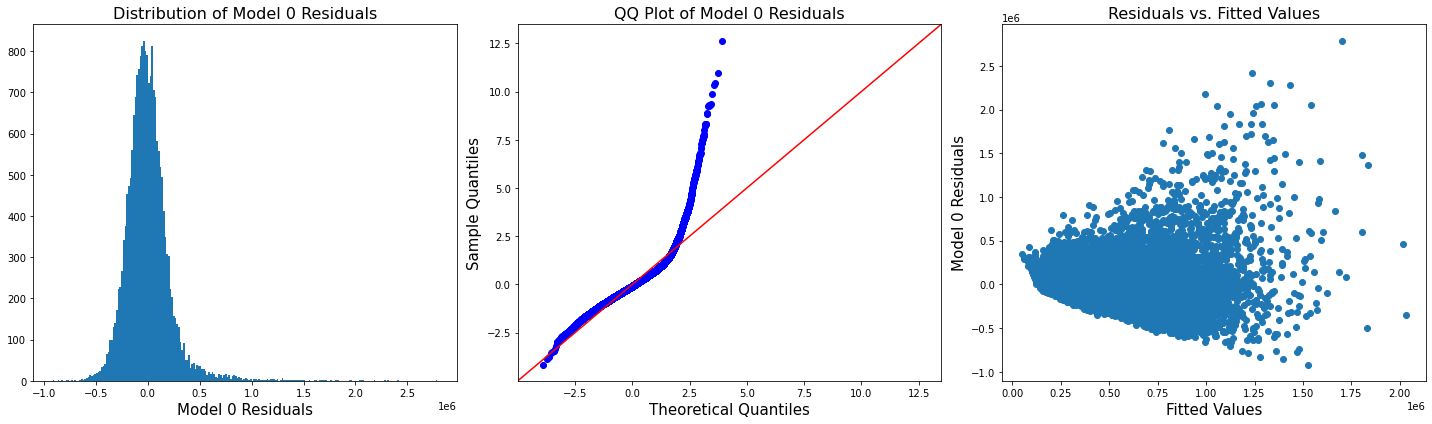

In [7]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20,6))

# DISPLAY RESIDUALS DISTRIBUTION, QQ PLOT, AND RESIDUALS VS. FITTED VALUES PLOT

def residual_diagnostics(f, a, model, num):
    a[0].hist(model.resid, bins = "auto")
    a[0].set_xlabel("Model {} Residuals".format(num), fontsize = 15)
    a[0].set_title("Distribution of Model {} Residuals".format(num), fontsize = 16);

    sm.qqplot(model.resid, line = "45", fit = True, ax = a[1]);
    a[1].set_xlabel("Theoretical Quantiles", fontsize = 15);
    a[1].set_title("QQ Plot of Model {} Residuals".format(num), fontsize = 16);
    a[1].set_ylabel("Sample Quantiles", fontsize = 15);

    a[2].scatter(x = model.fittedvalues, y = model.resid)
    a[2].set_xlabel("Fitted Values", fontsize = 15)
    a[2].set_ylabel("Model {} Residuals".format(num), fontsize = 15)
    a[2].set_title("Residuals vs. Fitted Values", fontsize = 16);

    f.tight_layout()

residual_diagnostics(fig, axes, baseline_model, 0)

At first glance, it seems like the model residuals *do* follow a normal distribution.  The histogram shows a clear bell-shaped distribution centred around 0, however, the QQ plot at the right reveals a heavy, positive skew.  This model therefore **violates the regression assumption of normally distributed residuals**.

Looking at the Residuals vs. Fitted Values plot, it's clear that the **regression assumption of residuals having a mean of 0 and constant spread has been violated**.  The residuals are clearly not centred around 0 and they seem to "fan out" as we move from left to right.

In order to compare this model with future models, we'll conduct 5-fold cross validation on the data and record the RMSE.

In [8]:
# function to create k-folds from input dataframe
# output is list of data frames (folds)
def kfolds(data, k):
    # Force data as pandas DataFrame
    data = pd.DataFrame(data)
    n = len(data)
    fold_size = n // k
    left = n % k
    folds = []
    i = 0
    for fold_n in range(1, k+1):
        if fold_n <= left:
            fold = data.iloc[i : i+fold_size+1]
            folds.append(fold)
            i += fold_size+1
        else:
            fold = data.iloc[i : i+fold_size]
            folds.append(fold)
            i += fold_size
    
    return folds

In [9]:
# import necessary functions from scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def cross_validation(data, resp, preds, k = 5, log = False):
    y = data[[resp]]
    X = data[preds]
    
    df = pd.concat([X, y], axis = 1)
    
    folds = kfolds(df, k)
    
    lr = LinearRegression()
    
    train_MSEs = []
    test_MSEs = []
    
    for n in range(k):
        # split into train and test data
        # k-1 folds
        train = pd.concat([folds[i] for i in range(len(folds)) if i != n], axis = 0)
        # nth fold
        test = folds[n]
        
        x_train = train.loc[:,train.columns != resp]
        y_train = train[resp]
        x_test = test.loc[:,test.columns != resp]
        y_test = test[resp]
        
        # create model with training data
        lr.fit(x_train, y_train)
        # calculate predictions using x_train and x_test
        y_hat_train = lr.predict(x_train)
        y_hat_test = lr.predict(x_test)
        # calculate MSE of train and test data and append
        if log:
            train_MSEs.append(mean_squared_error(np.exp(y_train), np.exp(y_hat_train)))
            test_MSEs.append(mean_squared_error(np.exp(y_test), np.exp(y_hat_test)))
        else:
            train_MSEs.append(mean_squared_error(y_train, y_hat_train))
            test_MSEs.append(mean_squared_error(y_test, y_hat_test))
    return np.mean(train_MSEs), np.mean(test_MSEs)

# record both MSEs
MSEs_baseline = cross_validation(df, response, baseline_predictors, 5)
# store train and test MSEs in corresponding list
train_MSEs.append(MSEs_baseline[0])
test_MSEs.append(MSEs_baseline[1])

print("The training MSE is:", MSEs_baseline[0], ".  The test MSE is:", MSEs_baseline[1])

The training MSE is: 48629126654.08553 .  The test MSE is: 49194161792.389915


Great, now we have our baseline, 5-fold cross validation MSE.  This is also considered the "residual variance" since we're summing up the squared deviations and dividing by the number of data points available.

### Model 1 - Applying Transformations and Following Regression Assumptions

Now that we've created our baseline model, let's try to improve it.  Recall from [Part I](HousingProject.ipynb)'s section 3.d. that `sqft_above`, `sqft_living`, `sqft_lot`, `sqft_living15`, and `sqft_lot15` had skewed distributions and we log-transformed them to resemble normal distributions.  These transformations *should* improve the performance of our model (specifically with the residual assumptions).  That being the case, we'll be using `df_transformed` from now on.

We'll first check for a linear relationship with the response variable and check the correlations between variables:

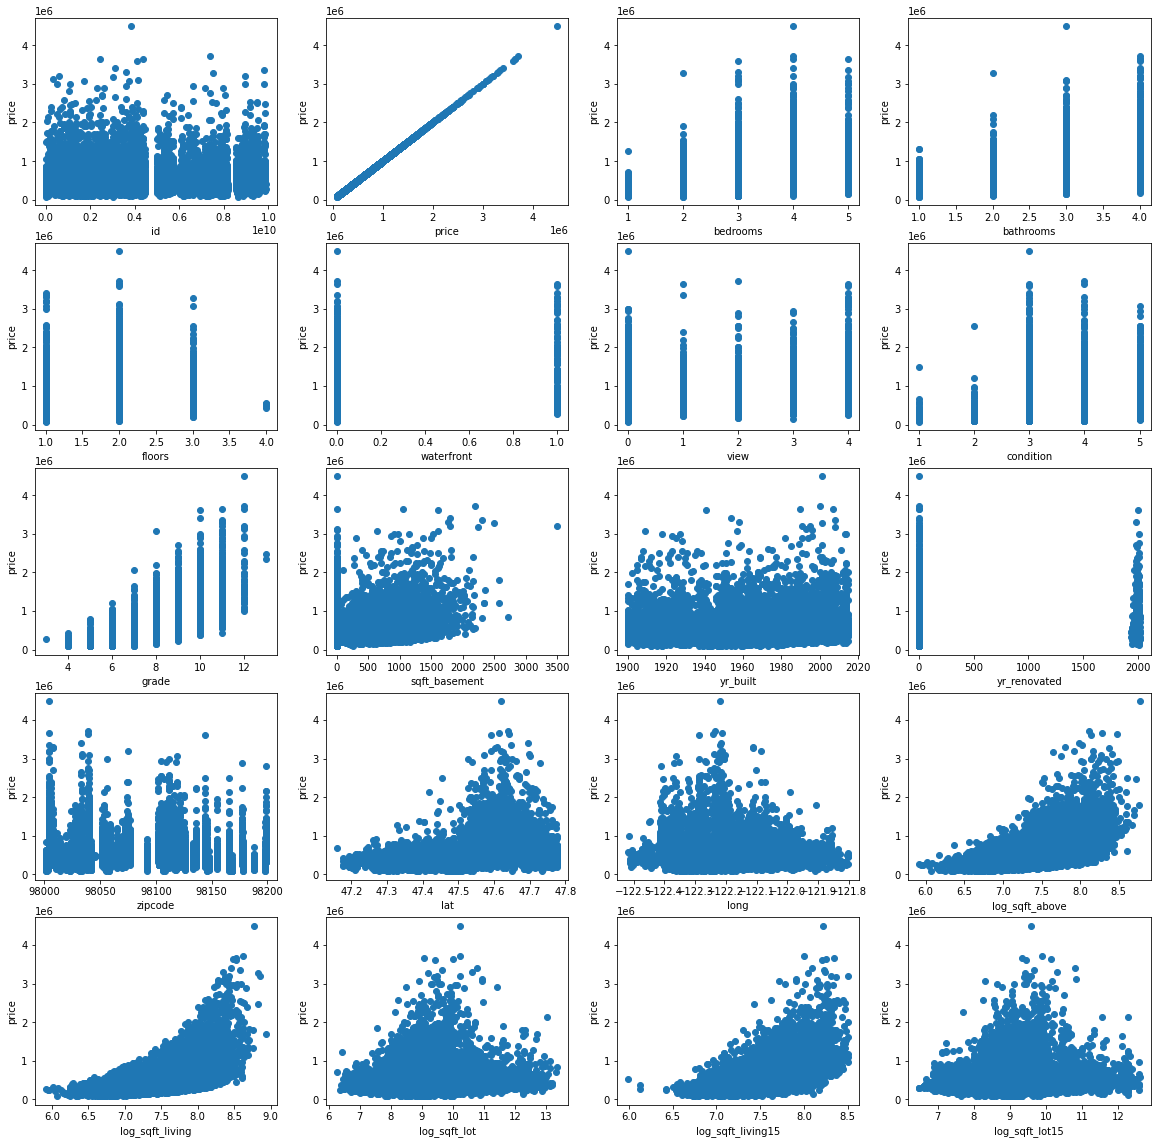

In [10]:
fig, axes = plt.subplots(nrows = 5, ncols = 4, figsize = (20,20))
# extracting only the numeric columns from df_transformed
df_numeric = df_transformed.select_dtypes(np.number)
# counter
index = 0
for row in range(len(axes)):
    for col in range(len(axes[row])):
        ax = axes[row][col]
        x = df_numeric.iloc[:,index]
        y = df_numeric["price"]
        ax.scatter(x = x, y = y)
        ax.set_xlabel(df_numeric.columns[index])
        ax.set_ylabel("price")
        index += 1

In [11]:
# correlation matrix of transformed data
df_transformed.corr()

,id,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,log_sqft_above,log_sqft_living,log_sqft_lot,log_sqft_living15,log_sqft_lot15
id,1.000000,-0.005665,0.013361,0.025274,0.025337,-0.001451,0.016757,-0.027716,0.021851,-0.003972,0.027931,-0.010753,-0.011298,0.000734,0.022418,0.013435,0.011811,-0.143267,0.006581,-0.140876
price,-0.005665,1.000000,0.291021,0.437820,0.250489,0.214350,0.378472,0.052137,0.656569,0.282853,0.035976,0.107118,-0.042919,0.343960,0.034767,0.519948,0.598216,0.134844,0.547354,0.126005
bedrooms,0.013361,0.291021,1.000000,0.480787,0.181019,-0.020126,0.056247,0.027568,0.365860,0.267572,0.188767,-0.001550,-0.177877,-0.030135,0.183822,0.528386,0.635479,0.195209,0.428121,0.179686
bathrooms,0.025274,0.437820,0.480787,1.000000,0.472710,0.029018,0.129408,-0.138535,0.641652,0.209803,0.567303,0.008481,-0.233409,0.005366,0.275459,0.667413,0.728820,0.044862,0.559859,0.047389
floors,0.025337,0.250489,0.181019,0.472710,1.000000,0.012875,0.014616,-0.219736,0.407138,-0.264830,0.377858,0.007131,-0.017757,0.061854,0.090068,0.514729,0.331677,-0.265467,0.226404,-0.258216
waterfront,-0.001451,0.214350,-0.020126,0.029018,0.012875,1.000000,0.346765,0.017227,0.062035,0.059400,-0.029975,0.053549,0.035251,-0.012234,-0.039399,0.039755,0.057191,0.067599,0.059647,0.078169
view,0.016757,0.378472,0.056247,0.129408,0.014616,0.346765,1.000000,0.049020,0.220026,0.248188,-0.067757,0.084911,0.093141,0.002318,-0.091161,0.126920,0.217639,0.106939,0.244530,0.106578
condition,-0.027716,0.052137,0.027568,-0.138535,-0.219736,0.017227,0.049020,1.000000,-0.147667,0.178336,-0.358932,-0.053930,-0.003626,-0.017495,-0.096899,-0.148460,-0.043991,0.087092,-0.086900,0.092833
grade,0.021851,0.656569,0.365860,0.641652,0.407138,0.062035,0.220026,-0.147667,1.000000,0.124793,0.453891,0.009077,-0.184709,0.113164,0.221201,0.727047,0.726434,0.152400,0.674201,0.158594
sqft_basement,-0.003972,0.282853,0.267572,0.209803,-0.264830,0.059400,0.248188,0.178336,0.124793,1.000000,-0.145463,0.055333,0.083114,0.108053,-0.150655,-0.103339,0.392310,0.082490,0.178290,0.072814


The scatter plots of each variable plotted against `price` reveal if the relationship between them is linear, nonlinear, or if there's no relationship whatsoever.  There don't seem to be any strong *linear* relationships, however, some variables *do* have a positive (or negative) relationship.  `bathrooms`, `grade`, `sqft_basement`, `lat`, `log_sqft_above`, `log_sqft_living`, and `log_sqft_living15` seem to have a positive relationship with `price`.

Furthermore, the correlation matrix reveals some multicollinearity problems.  Generally, a correlation greater than |0.8| is cause for concern.  For example, `log_sqft_living` - `log_sqft_above` have a correlation coefficient of 0.85 and `log_sqft_lot` - `log_sqft_lot15` have a correlation coefficient of 0.92.  This makes sense since the sqare footage of a house's interior living space would be highly correlated with the square feet above ground.

After checking for the linearity assumption and the no multicollinearity assumption, the chosen variables for Model 1 are the predictors from baseline_model (transformed) + `grade`, `log_sqft_living15`, and getting rid of `log_sqft_above`.  We won't include `log_sqft_above` given its high correlation to `log_sqft_living`.  No categorical variables for this model yet.  This model is to measure how Adjusted R-squared is affected by transformations and an attempt to follow the assumptions:

In [12]:
# Y
response = "price"
# X
predictors = ["bedrooms", "bathrooms", "log_sqft_living", "yr_built", 
              "grade", "log_sqft_living15"]
# R-styled formula
f = response + " ~ " + " + ".join(predictors)
# fit the model
model_one = ols(formula = f, data = df_transformed).fit()

### Evaluating Model 1

In [13]:
model_one.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     4484.
Date:                Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:05:52   Log-Likelihood:            -2.8214e+05
No. Observations:               20667   AIC:                         5.643e+05
Df Residuals:                   20660   BIC:                         5.644e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5.263e+06   1.31e+05     40.312      0.000    5.01e+06    5.52e+06
bedrooms          -3.005e+04   2301.868    -13.055      0.000   -3.46e+04   -2.55e+04
bathrooms           4.36e+04   2788.152     15.636      0.000    3.81e+04    4.91e+04
log_sqft_living    1.624e+05   7576.735     21.438      0.000    1.48e+05    1.77e+05
yr_built          -4031.0956     61.145    -65.926      0.000   -4150.946   -3911.246
grade              1.542e+05   2078.300     74.198      0.000     1.5e+05    1.58e+05
log_sqft_living15  1.062e+05   6988.580     15.193      0.000    9.25e+04     1.2e+05
==============================================================================
Omnibus:                    12814.778   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           312128.253
Skew:                           2.562   Prob(JB):                         0.00
Kurtosis:                      21.336   Cond. No.                     1.80e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our Adjusted R-squared statistic increased to 0.565 and all our predictors are considered significant.

Let's see if the residual assumptions hold:

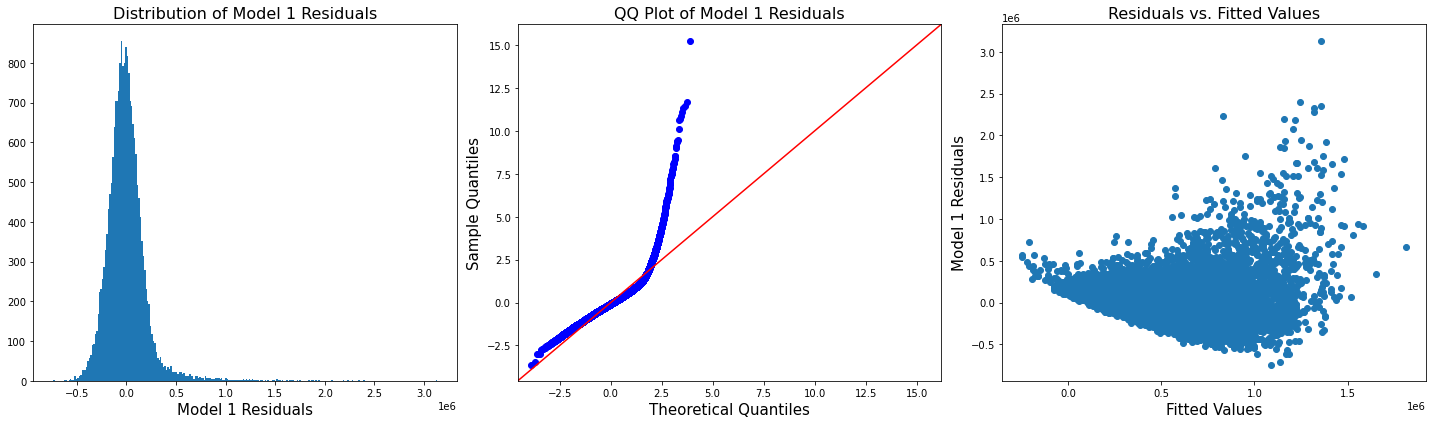

In [14]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20,6))

residual_diagnostics(fig, axes, model_one, 1)

As with the baseline model, the normality assumption seems to hold until we see the QQ plot and notice a heavy, positive skew.  The constant spread and mean of 0 assumption also fails since the residuals are not scattered evenly in the Residuals vs. Fitted Values plot.

Now, we record the 5-fold cross validated MSE to compare it with the baseline model:

In [15]:
MSEs_model1 = cross_validation(df_transformed, response, predictors, 5)
train_MSEs.append(MSEs_model1[0])
test_MSEs.append(MSEs_model1[1])
print("The training MSE is:", MSEs_model1[0], ".  The test MSE is:", MSEs_model1[1])

The training MSE is: 42150133214.567276 .  The test MSE is: 42684571367.162125


The MSE dropped to 42,684,571,367 from 49,194,161,792!  Our model is performing slightly better.

### Model 2 - Transforming Price

Recall from [Part I](HousingProject.ipynb) that `price` had a positively skewed distribution.  In this model, we'll be log-transforming `price` to approach a normal distribution and see if that helps us reach linear relationships:

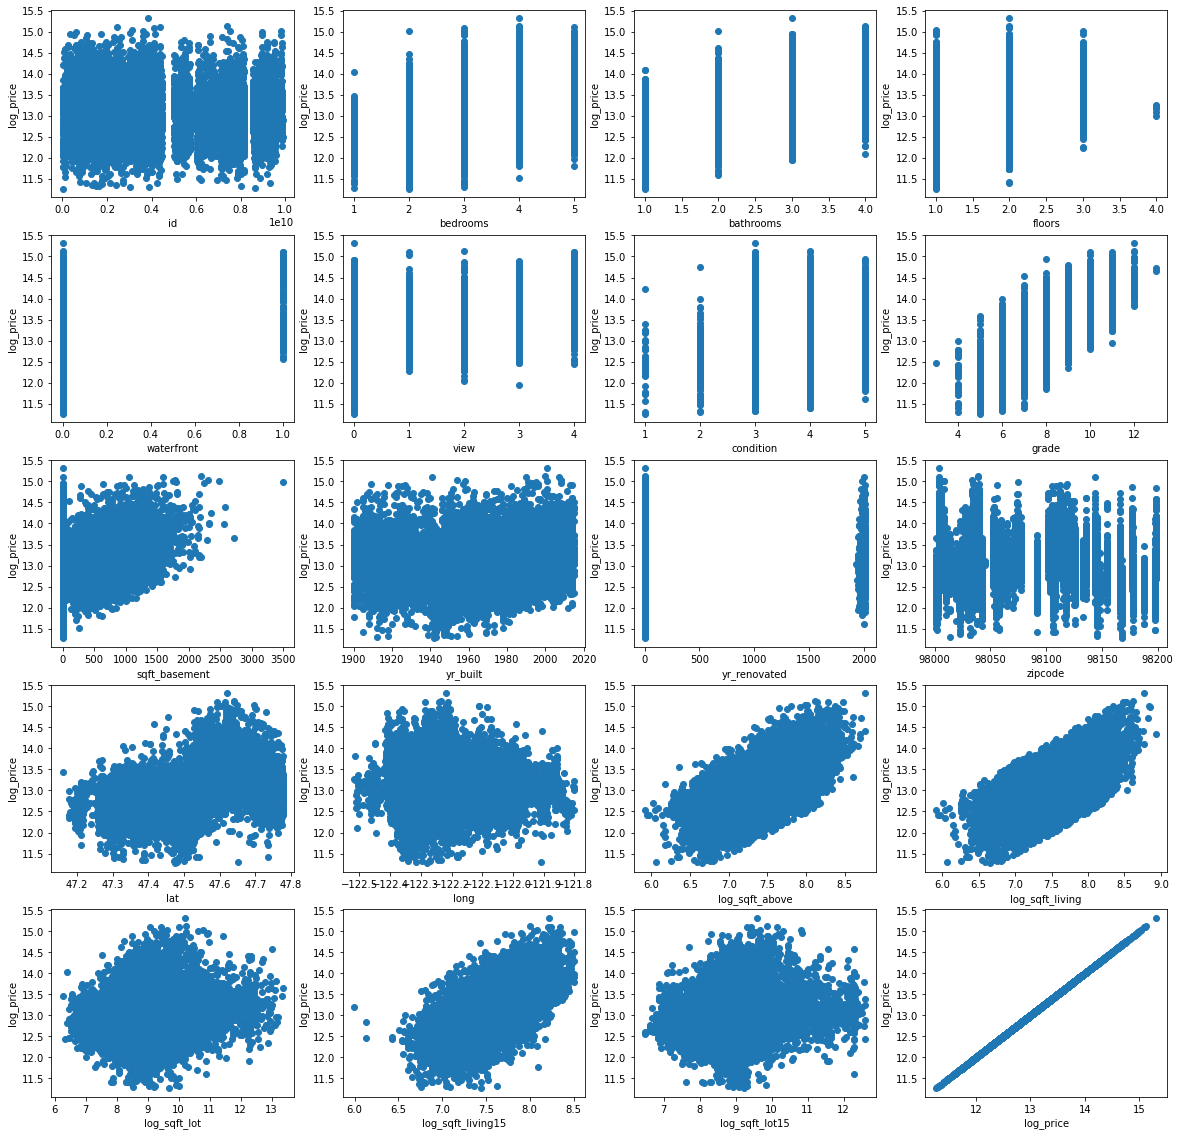

In [16]:
# creating a copy to keep on using df_transformed just in case
df_model_two = df_transformed.copy()
# feature engineering!
df_model_two["log_price"] = np.log(df_model_two["price"])
# drop price
df_model_two.drop("price", axis = 1, inplace = True)

fig, axes = plt.subplots(nrows = 5, ncols = 4, figsize = (20,20))
# extracting only the numeric columns from df_model_two
df_numeric = df_model_two.select_dtypes(np.number)
# counter
index = 0
for row in range(len(axes)):
    for col in range(len(axes[row])):
        ax = axes[row][col]
        x = df_numeric.iloc[:,index]
        y = df_numeric["log_price"]
        ax.scatter(x = x, y = y)
        ax.set_xlabel(df_numeric.columns[index])
        ax.set_ylabel("log_price")
        index += 1
plt.savefig("./images/scatter.png", dpi = 150, bbox_inches = "tight")

In [17]:
df_model_two.corr()["log_price"]

id                   0.009400
bedrooms             0.323903
bathrooms            0.486023
floors               0.297147
waterfront           0.140556
view                 0.321127
condition            0.048041
grade                0.678346
sqft_basement        0.283375
yr_built             0.066043
yr_renovated         0.093947
zipcode             -0.030457
lat                  0.465281
long                 0.066631
log_sqft_above       0.551964
log_sqft_living      0.646713
log_sqft_lot         0.110164
log_sqft_living15    0.587664
log_sqft_lot15       0.100173
log_price            1.000000
Name: log_price, dtype: float64

After log-transforming `price`, it is clear that some relationships (between predictor and `price`) have become stronger and more linear.  For example, `bedrooms` now has more of a positive relationship with `price` than before, `log_sqft_living`'s relationship became more linear, `grade` improved, etc.

Given that we only transformed the response variable `price`, the correlations between the variables will remain the same and the same multicollinearity issues are found as in Model 1.

For this model, we'll include the same predictors we did in Model 1 + `sqft_basement` and `view`.

In [18]:
# Y
response = "log_price"
# X
predictors = predictors + ["sqft_basement", "view"]
# R-styled formula
f = response + " ~ " + " + ".join(predictors)
# fit the model
model_two = ols(formula = f, data = df_model_two).fit()

### Evaluating Model 2

In [19]:
model_two.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     4119.
Date:                Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:06:28   Log-Likelihood:                -5341.1
No. Observations:               20667   AIC:                         1.070e+04
Df Residuals:                   20658   BIC:                         1.077e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            19.1119      0.202     94.395      0.000      18.715      19.509
bedrooms             -0.0433      0.004    -12.275      0.000      -0.050      -0.036
bathrooms             0.0831      0.004     19.497      0.000       0.075       0.091
log_sqft_living       0.2790      0.012     22.511      0.000       0.255       0.303
yr_built             -0.0058    9.8e-05    -59.034      0.000      -0.006      -0.006
grade                 0.2251      0.003     69.776      0.000       0.219       0.231
log_sqft_living15     0.1884      0.011     17.409      0.000       0.167       0.210
sqft_basement      3.582e-05   6.25e-06      5.730      0.000    2.36e-05    4.81e-05
view                  0.0609      0.003     19.051      0.000       0.055       0.067
==============================================================================
Omnibus:                       52.747   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.676
Skew:                          -0.114   Prob(JB):                     2.21e-12
Kurtosis:                       3.101   Cond. No.                     1.85e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The inclusion of `sqft_basement`, `view`, and log-transforming `price` has increased our Adjusted R-squared value to 0.615.  This is better than Model 1 *and* Baseline Model, but still isn't great.

Now to check for the residual assumptions:

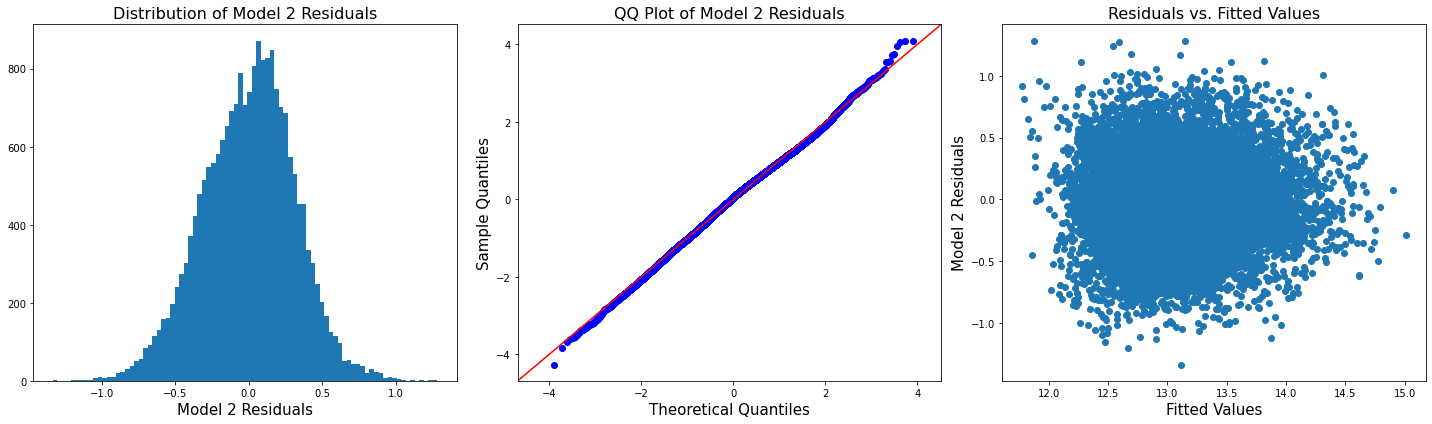

In [20]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20,6))

residual_diagnostics(fig, axes, model_two, 2)

This time it *does* seem the residual assumptions were met.  The residuals appear to be normally distributed, as evidenced by the histogram and QQ plot, and are somewhat centred around 0 with a semi-constant spread.  Despite its small increase in Adjusted R-squared, Model 2 did manage to fulfill the residual regression assumptions.

Finally, let's compute the MSE to compare it to the previous two models:

In [21]:
MSEs_model2 = cross_validation(df_model_two, response, predictors, 5, True)
train_MSEs.append(MSEs_model2[0])
test_MSEs.append(MSEs_model2[1])
print("The training MSE is:", MSEs_model2[0], ".  The test MSE is:", MSEs_model2[1])

The training MSE is: 35285117651.31549 .  The test MSE is: 36031850696.5778


Compared to the previous two MSEs, the 5-fold cross-validated MSE for Model 2 dropped quite a bit.  This is good news since it means the residual variance is shrinking

### Model 3 - Challenging the Regression Assumptions

**Disclaimer**: It is important to note that the regression assumptions are ideals and an important guideline to follow, in general.  However, real-world data is often times messy and won't always fit the rules of regression.  It is also important to note that regression models are robust and can still perform well despite sometimes challenging or violating the regression assumptions.  Therefore, regression models should strive to follow the assumptions as much as possible, but can *sometimes* violate them in order to perform better.

That being said, this model will include some variables that don't necessarily have much of a *linear* relationship with `log_price`, but have a relationship nonetheless.

Model 3 will include all the previous variables and will add `floors`, `lat`, and `waterfront`.

In [22]:
# Y
response = "log_price"
# X
predictors = predictors + ["floors", "lat", "waterfront"]
# R-styled formula
f = response + " ~ " + " + ".join(predictors)
# fit the model
model_three = ols(formula = f, data = df_model_two).fit()

### Evaluating Model 3

In [23]:
model_three.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     5537.
Date:                Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:06:40   Log-Likelihood:                -1004.1
No. Observations:               20667   AIC:                             2032.
Df Residuals:                   20655   BIC:                             2127.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -47.3495      0.687    -68.941      0.000     -48.696     -46.003
bedrooms             -0.0257      0.003     -8.970      0.000      -0.031      -0.020
bathrooms             0.0516      0.004     14.291      0.000       0.045       0.059
log_sqft_living       0.3242      0.010     31.736      0.000       0.304       0.344
yr_built             -0.0041   8.12e-05    -50.804      0.000      -0.004      -0.004
grade                 0.1681      0.003     62.673      0.000       0.163       0.173
log_sqft_living15     0.2053      0.009     22.979      0.000       0.188       0.223
sqft_basement      2.251e-05   5.66e-06      3.977      0.000    1.14e-05    3.36e-05
view                  0.0693      0.003     25.092      0.000       0.064       0.075
floors                0.0588      0.004     14.433      0.000       0.051       0.067
lat                   1.3264      0.013     99.551      0.000       1.300       1.353
waterfront            0.3161      0.023     13.835      0.000       0.271       0.361
==============================================================================
Omnibus:                      353.864   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              698.983
Skew:                           0.060   Prob(JB):                    1.65e-152
Kurtosis:                       3.893   Cond. No.                     7.74e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The inclusion of `floors`, `lat`, and `waterfront` increased our Adjusted R-squared statistic to 0.747.  It is also important to note that all predictors were deemed "significant" with respective p-values < 0.05.

Let's see if this model met the residual assumptions:

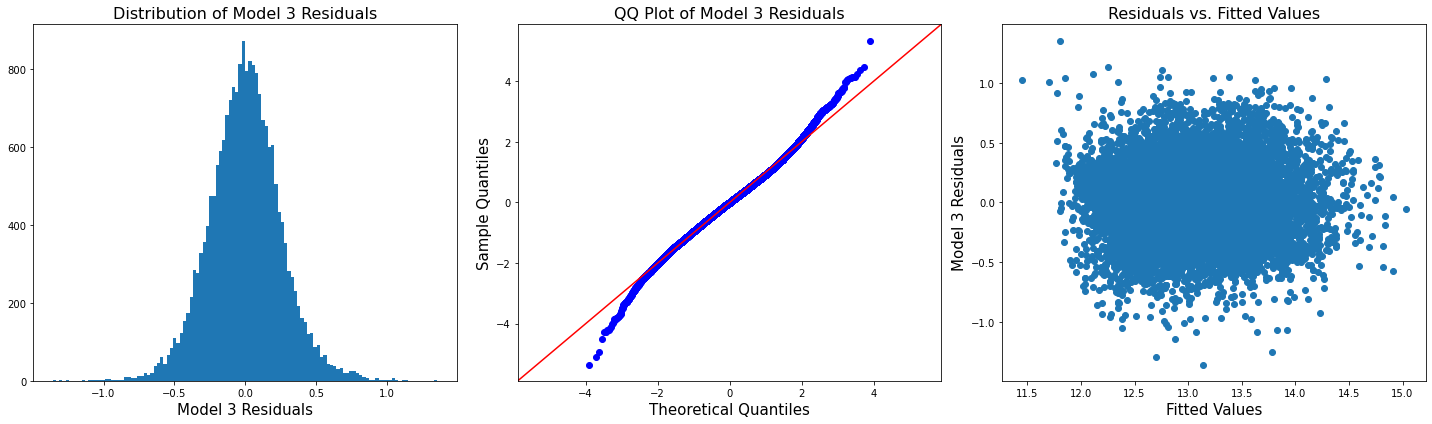

In [24]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20,6))

residual_diagnostics(fig, axes, model_three, 3)
plt.savefig("./images/diagnostics.png", dpi = 150, bbox_inches = "tight")

Once again, it seems the residual assumptions were met!  The QQ plot reveals some skewness at the ends (compared to Model 2), but the residuals are still roughly normally distributed.  The Residuals vs. Fitted Values plot didn't change much from Model 2 and the assumption of zero mean and constant spread roughly holds.

Let's check the MSE for this model and see how it fares:

In [25]:
MSEs_model3 = cross_validation(df_model_two, response, predictors, 5, True)
train_MSEs.append(MSEs_model3[0])
test_MSEs.append(MSEs_model3[1])
print("The training MSE is:", MSEs_model3[0], ".  The test MSE is:", MSEs_model3[1])

The training MSE is: 28521882759.010284 .  The test MSE is: 28969174816.787273


Great.  Both the training and test MSE values have decreased from Model 2.

----------

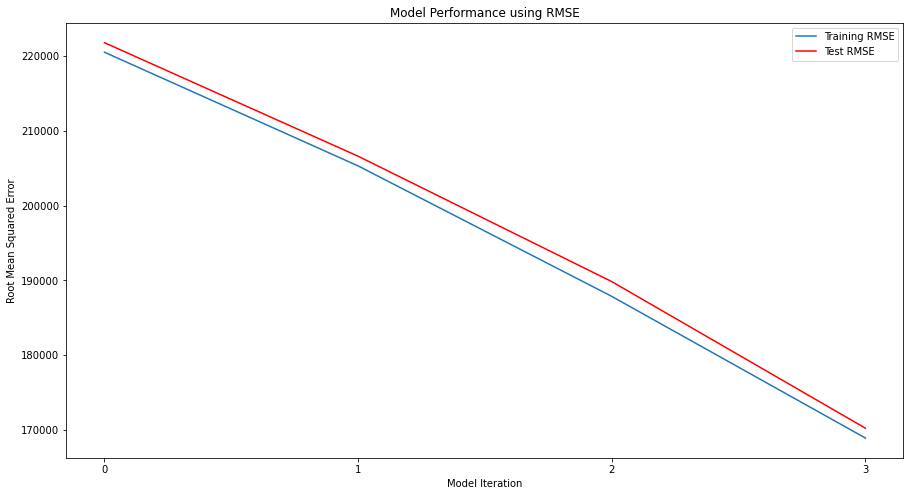

In [26]:
# plotting RMSE with each model to see how performance changed

plt.figure(figsize = (15,8))
plt.xticks(np.arange(0,4))
plt.plot(np.arange(0,4), np.sqrt(train_MSEs), label = "Training RMSE")
plt.plot(np.arange(0,4), np.sqrt(test_MSEs), color = "r", label = "Test RMSE")
plt.legend()
plt.xlabel("Model Iteration")
plt.ylabel("Root Mean Squared Error")
plt.title("Model Performance using RMSE");

plt.savefig("./images/cross_validation.png", dpi = 150, bbox_inches = "tight")

As seen by the graph above, the *Root Mean Squared Error (RMSE)* decreased with each model iteration.  We're mainly interested in the "Test RMSE" since this is a measure of how well our model predicts house sale prices on unseen data.  Even though we always recorded the MSE after each cross validation, the RMSE is plotted above since this is easier to interpret.  After all the transformations and dropping/adding variables, our final model has a RMSE of around 170,000.

## Final Model Summary

After creating 4 different models for this dataset, I believe Model 3 does the best job at fitting the data and meeting the regression assumptions.  Despite somewhat violating the linear relationship regression assumption, Model 3 meets the residual and multicollinearity assumptions pretty well.  Also, the number of predictors is reasonable (not too much which would possibly overfit the data, and not too few which would lead to a low R-squared and underfitting the data).  It is also important to note that all the predictors in Model 3 were deemed "significant" which means they *do* have an impact on the response variable: log(`price`).

### Interpreting Beta Coefficients

Without going into each of the 10 predictor variables, here is the interpretation of the beta coefficient for 3 of them:

- `grade`: one unit increase in `grade` is associated with a 16.79% increase in `price`

- `log_sqft_living`: one percent increase in `sqft_living` is associated with a 0.32% increase in `price`

- `floors`: one unit increase in `floors` is associated with a 5.9% increase in `price`

### The importance of `grade` and `log_sqft_living`

Of all the predictor variables used in Model 3, it is important to highlight `grade` and `log_sqft_living`.  Besides having semi-linear relationships with the response variable and being labelled as significant, these two variables stand out from the rest when it comes to correlation with `price`.  Even though the other predictors are significant and might have had a slight linear relationship with the response variable, their correlations weren't nearly as high as `grade` and `log_sqft_living`.  Often times it is very easy to get lost in between so many predictor variables and seeing all of them with a p-value < 0.05.  However, when it comes to the variables that played a key role in predicting `price`, `grade` and `log_sqft_living` should be mentioned.

## Future Work

Even though this project dealt with creating regression models through an iterative process of constantly evaluating and tweaking variables, there are still *plenty* of other changes/transformations that could be performed.  For example, the final model only uses 1 categorical variable (`waterfront`) but the original dataset contained many more.  Furthermore, interactions between variables was not taken into account and could be something worth investigating.  Finally, another variable that we did not consider in this project was `zipcode`.  You know what they say when buying a house... "LOCATION, LOCATION, LOCATION"!  This could be another variable worth investigating!

------